In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Path Management

In [2]:
path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\PXFront"
spx_path  = os.path.join(path, "ES.parquet")

# Make Signature Plot

In [3]:
def prep_data(path: str) -> pd.DataFrame:

    df_out = (pd.read_parquet(
        path = path, engine = "pyarrow").
        assign(date = lambda x: pd.to_datetime(x.date)).
        drop(columns = ["security"]).
        rename(columns = {"PX_LAST": "price"}).
        set_index("date"))
    
    return df_out

df_spx = prep_data(spx_path)

In [4]:
def get_all_data() -> pd.DataFrame:
    
    full_path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\data\PXFront"
    paths = [os.path.join(full_path, path) for path in os.listdir(full_path) if path != "NG.parquet" and path != "UX.parquet"]
    dfs = pd.concat([prep_data(path).assign(security = path.split("\\")[-1].split(".")[0]) for path in paths])
    
    return dfs

df_all = get_all_data()

In [5]:
def get_signature_plot(df: pd.DataFrame) -> pd.DataFrame: 
    
    rtns = df.pct_change().price.dropna()
    timesteps = [int(i + 1) for i in range(200)]
    stds = [
        (rtns.rolling(window = timestep).std().mean()) / rtns.std()
        for timestep in timesteps]

    df_signature = (pd.DataFrame({
        "timestep": timesteps,
        "stds": stds}).
        dropna().
        set_index("timestep"))
    
    return df_signature

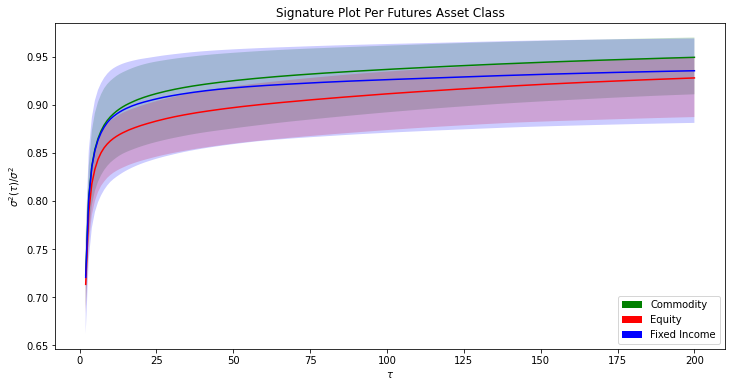

In [6]:
def make_singature_plot(df_all: pd.DataFrame) -> plt.Figure: 

    df_signature_plot = (df_all.groupby(
        "security").
        apply(get_signature_plot).
        reset_index())

    path = r"C:\Users\Diego\Desktop\app_prod\BBGFuturesManager\root\fut_tickers.xlsx"
    df_kind = (pd.read_excel(
        io = path, sheet_name = "px")
        [["contract", "kind"]].
        rename(columns = {"contract": "security"}))

    df_combined = (df_signature_plot.merge(
        right = df_kind, how = "inner",on = ["security"]))

    colors = {
        "Commodity": "Green",
        "Equity": "Red",
        "Fixed Income": "Blue"}

    legend_elements = [Patch(facecolor = colors[security_kind], label = security_kind) for security_kind in colors.keys()]
    fig, axes = plt.subplots(figsize = (12,6))
    for contract_kind in colors.keys():

        df_plot = (df_combined.query(
            "kind == @contract_kind").
            drop(columns = ["kind"]).
            pivot(index = "timestep", columns = "security", values = "stds"))

        df_minmax = (df_plot.reset_index().melt(
            id_vars = "timestep").
            drop(columns = ["security"]).
            groupby("timestep").
            agg(["min", "max"])
            ["value"])

        axes.fill_between(
            x = df_minmax.index,
            y1 = df_minmax["min"],
            y2 = df_minmax["max"],
            alpha = 0.2,
            facecolor = colors[contract_kind])

        df_plot.mean(axis = 1).plot(color = colors[contract_kind])

        axes.legend(handles = legend_elements, loc = "lower right")
        axes.set_xlabel(r"$\tau$")
        axes.set_ylabel(r"$\sigma^2(\tau)/\sigma^2$")
        axes.set_title("Signature Plot Per Futures Asset Class")
        
make_singature_plot(df_all)

# Prepping Time Series

We are going to normalize the returns of the strategy to make strategies unit variance. They use a method to get the EWMA of daily volatility. <br>
$$
\begin{equation}
\sigma_t := \gamma \sqrt{\mathcal{L}_{\tau_{\sigma}}[D_t^2]}
\end{equation}
$$
Then apply that to the Returns $R_t$
$$
\begin{equation}
R_t = \frac{D_t}{\sigma_{t-1}}
\end{equation}
$$
They authors set these parameters as $\gamma = 1.05$ and $\tau_{\sigma} = 10$.

In [95]:
def _get_norm_rt(df: pd.DataFrame, tau: int = 10) -> pd.DataFrame: 
    
    df_out = (df_spx.assign(
        px_diff = lambda x: x.price.diff(),
        vol = lambda x: x.px_diff.apply(
            lambda y: y ** 2).
            ewm(span = tau, adjust = False).mean().
            apply(lambda z: np.sqrt(z)).shift(),
        r_t = lambda x: x.px_diff / x.vol))
    
    return df_out

df_rtn = _get_norm_rt(df_spx)

# Simple Trend Model

The authors begin with the following relationship between the performance of the trend and the variance of the returns.

$$
\begin{aligned}
\mathcal{G}_T &= \sum_{t = 1}^T G_t\\
            &=\frac{\lambda}{2} \left( \left( \sum_{t=1}^T R_t \right)^2 - \sum_{t=1}^T R_t^2 \right)\\
\end{aligned}
$$

They use a trend following signal on prior returns $\mathcal{L}_{\tau}(R_t)$. An analog relationship follows <br>
\begin{equation}
\mathcal{L}_{\tau'}[G_t] = \frac{\lambda \tau}{\tau - 1} \left( \tau \mathcal{L}_{\tau}^2[R_t] - \mathcal{L}_{\tau'}[R_t^2]\right) 
\end{equation}
Where $\tau'$ follows <br>
\begin{align}
\tau' &= \frac{\tau}{2} + \frac{1}{2\tau}\\
&\thickapprox \frac{\tau}{2}
\end{align}

Let's make a simple trend following model with EWMA. The authors set lookback windows using 5 days, 20 days, 60 days for weekly, monthly, and bi-annually.

In [96]:
def _make_prediction(df: pd.DataFrame, window: int, lambda_: float = 0.001) -> pd.DataFrame: 

    lambda_val = lambda_ / np.sqrt(window)
    df_rtn = _get_norm_rt(df)
    
    df_prediction = (df_rtn.dropna().assign(
        window = window, 
        left_side = lambda x: (np.sign(
            x.r_t.ewm(span = window, adjust = False).mean().shift()) * x.r_t).
            cumsum(),
        right_side = lambda x: 1000 * lambda_val * (
            window / (window - 1) * 
            (
                (window * (x.r_t.ewm(span = window, adjust = False).mean() ** 2)).cumsum() - 
                ((x.r_t ** 2).ewm(span = window / 2, adjust = False).mean()).cumsum())))
        [["left_side", "right_side", "window"]])
    
    return df_prediction

def make_prediction(df_rtn: pd.DataFrame, lookbacks: list = [5, 20, 60]) -> pd.DataFrame: 
    
    df_predictions = pd.concat([_make_prediction(df_rtn, window) for window in lookbacks])
    return df_predictions

df_predictions = make_prediction(df_spx)

With respect to the plots there are some caveats. Putting each side of the equation on seperate axes leads to some scaling problems. To show this create seperate lookback windows. There is also a slight problem with the EWMA on the beginning dates that have to be artificially sliced out (to be technical its around 30 points). 

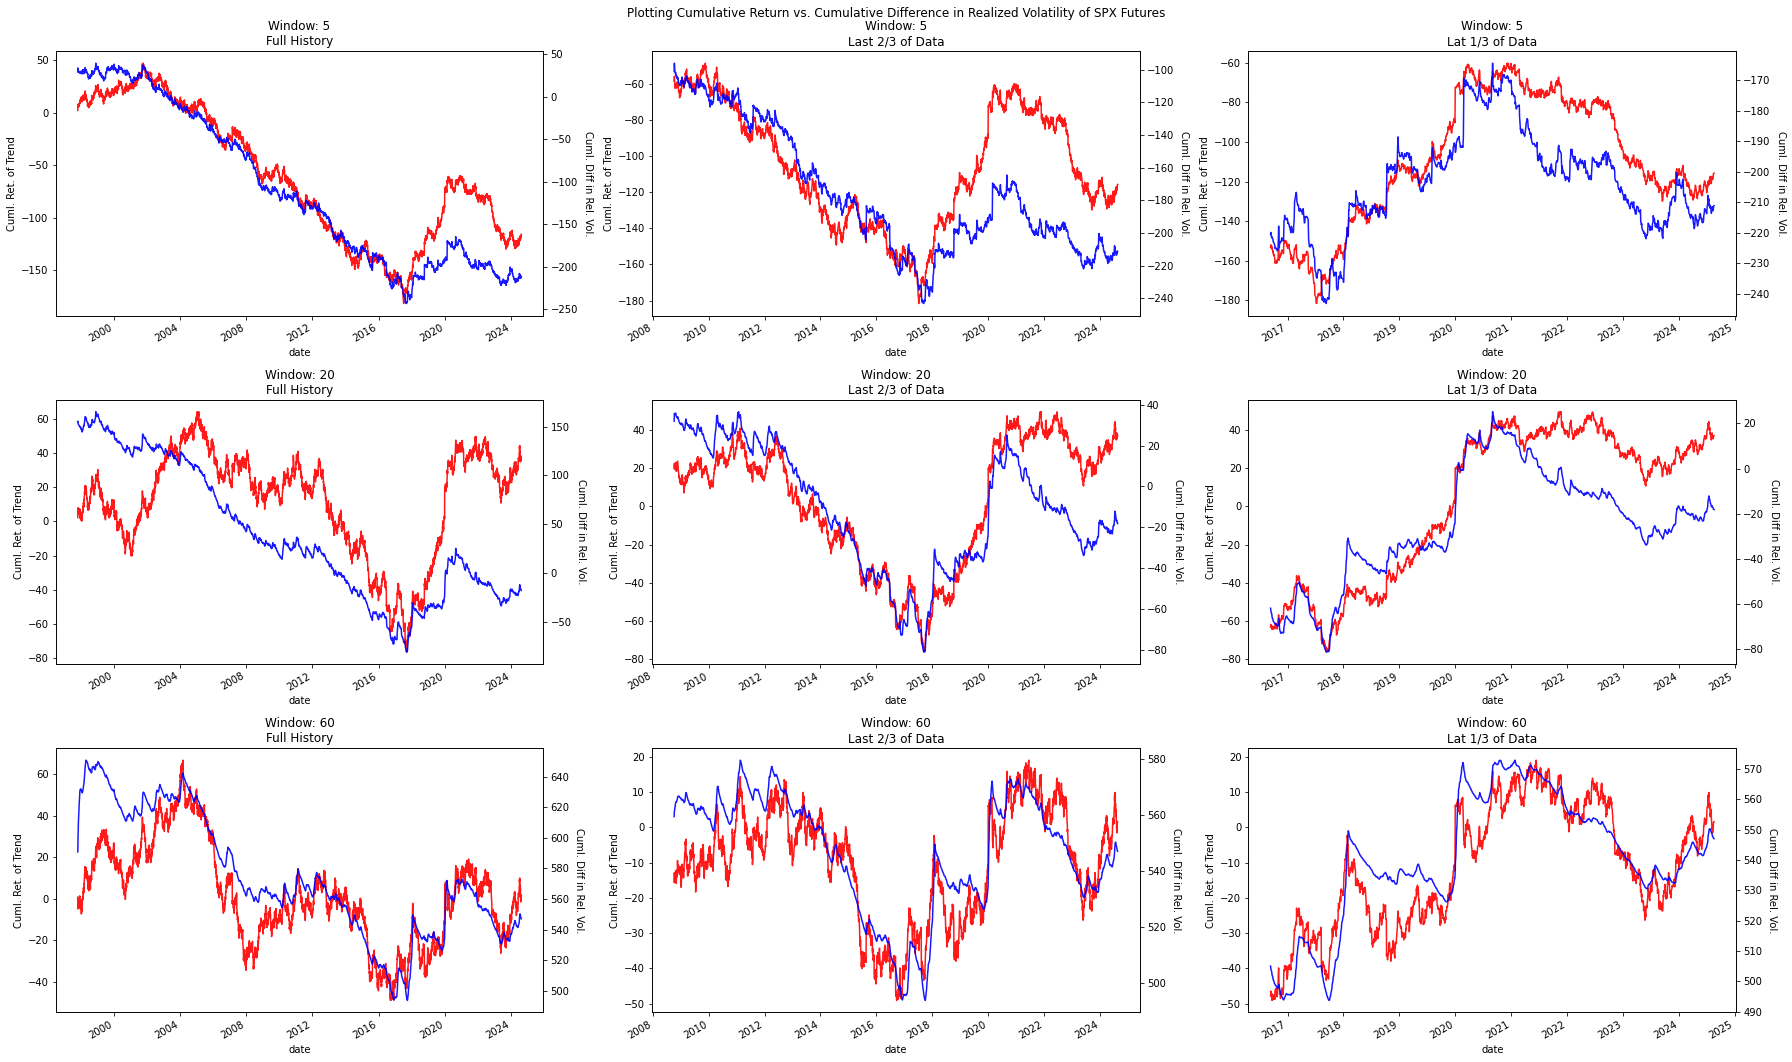

In [122]:
def _tmp_plot(df_tmp: pd.DataFrame, i: int, j: int, window: int, ax, name):
    
    ax_copy = ax[i,j].twinx()
    
    (df_tmp.left_side.plot(
        ax = ax[i,j],
        color = "red",
        alpha = 0.9))
    
    (df_tmp.right_side.plot(
        ax = ax_copy,
        color = "blue",
        alpha = 0.9,
        title = "Window: {}\n{}".format(window, name)))

    ax[i,j].set_ylabel("Cuml. Ret. of Trend")
    ax_copy.set_ylabel("Cuml. Diff in Rel. Vol.", rotation = 270, labelpad = 15)
    
def plot_predictions(df_predictions: pd.DataFrame) -> plt.Figure: 
    
    lookbacks = df_predictions.window.drop_duplicates().to_list()

    right_ylabel = r"$\frac{\lambda \tau}{\tau - 1} \left( \tau \mathcal{L}_{\tau}^2[R_t] - \mathcal{L}_{\tau'}[R_t^2]\right)$" 
    left_ylabel = r"$\mathcal{L}_{\tau'}[G_t]$"

    title_namer = {
        4_000: "Last 2/3 of Data",
        2_000: "Lat 1/3 of Data"}

    fig, axes = plt.subplots(ncols = len(lookbacks), nrows = 3, figsize = (25,15))
    for i, lookback in enumerate(lookbacks): 

        df_tmp = (df_predictions.query(
            "window == @lookback").
            drop(columns = ["window"]).
            iloc[30:])

        _tmp_plot(df_tmp, i, 0, lookback, axes, "Full History")
        _tmp_plot(df_tmp.tail(4_000), i, 1, lookback, axes, title_namer[4_000])
        _tmp_plot(df_tmp.tail(2_000), i, 2, lookback, axes, title_namer[2_000])

    fig.suptitle("Plotting Cumulative Return vs. Cumulative Difference in Realized Volatility of SPX Futures")
    plt.tight_layout()
    
plot_predictions(df_predictions)